# Visão Computacional - Lista 1

Aqui serão resolvidas as atividades da primeira lista de Visão Computacional pelo aluno Sillas Rocha da Costa, começaremos realizando alguns imports:

In [1]:
import cv2 as cv
import sys
import matplotlib.pyplot as plt
import numpy as np

Agora veremos se a leitura de imagens do opencv está funcionando sem mais problemas, ao usar a biblioteca do matplotlib para plotar as imagens, se baseando no post do github de [como plotar imagens em um notebook](https://gist.github.com/mstfldmr/45d6e47bb661800b982c39d30215bc88).

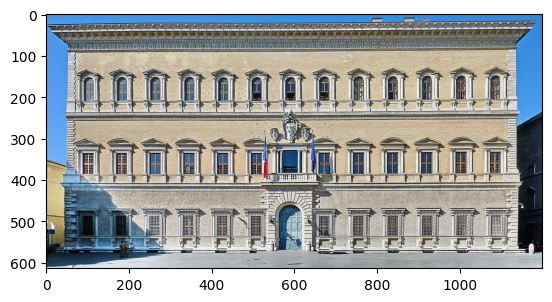

In [2]:
img_1 = cv.imread('./Palazzo_Farnese_Fassade.jpg')
img_1 = img_1[:,:,::-1]
plt.imshow(img_1)

# Exercício 1 - Rotação de uma Imagem

Agora, se baseando na função de base de rotação passada, criaremos a função my_rotation, com as matrizes de translação e rotação respectivamente seguindo:

```python
matriz_translacao = np.array([
    [1, 0, -centro[0]],
    [0 ,1, -centro[1]],
    [0, 0, 1]
])

matriz_rotacao = np.array([
    [np.cos(angulo), -np.sin(angulo), 0],
    [np.sin(angulo), np.cos(angulo), 0],
    [0, 0, 1]
])
```


In [3]:
def my_rotation(img:np.ndarray, angulo:float, centro:list) -> np.ndarray:
    
    # nessa primeira parte, vamos definir a transformação que leva a posicao dos pixels da imagem original
    # para a posicao dos pixels do imagem rotacionada.

    # a primeira matriz de translação muda a origem das coordenadas do canto da imagem para o centro da imagem
    matriz_translacao = np.array([
        [1, 0, -centro[0]],
        [0 ,1, -centro[1]],
        [0, 0, 1]
    ])

    # a matriz de rotacao aplica a rotacao em torno da origem
    matriz_rotacao = np.array([
        [np.cos(angulo), -np.sin(angulo), 0],
        [np.sin(angulo), np.cos(angulo), 0],
        [0, 0, 1]
    ])
    
    # a composicao coloca todas as matrizes em uma só: aplica a translacao (muda a origem), rotaciona, volta para a origem anterior
    matriz_composicao = np.linalg.inv(matriz_translacao) @ matriz_rotacao @ matriz_translacao

    # criar imagem rotacionada em preto, com mesmas dimensões da original
    lines, columns = img.shape[:2]
    rotated_image = np.zeros((lines, columns ,3), np.uint8)
    # o próximo passo é percorrer cada pixel da nova imagem e verificar qual é o pixel correspondente na imagem original

    for line in range(lines):
        for col in range(columns):
            pos_orig = np.array([line, col, 1])
            pos_rot = matriz_composicao @ pos_orig

            new_line = round(pos_rot[0])
            new_col = round(pos_rot[1])
        
            if (new_line >= 0 and new_line < lines) and (new_col >= 0 and new_col < columns):
                rotated_image[new_line, new_col] = img[line, col]
                
    return rotated_image

E então aplicaremos a função à nossa imagem, ao obter o resultado:

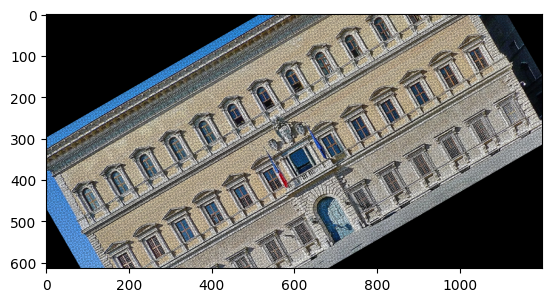

In [4]:
height, width = img_1.shape[:2]
centro = (height/2, width/2)
angulo = np.pi/6
my_rotated_image = my_rotation(img_1, angulo, centro)

plt.imshow(my_rotated_image)

Ao comparar com a função da biblioteca opencv, vemos que está funcionando corretamente.

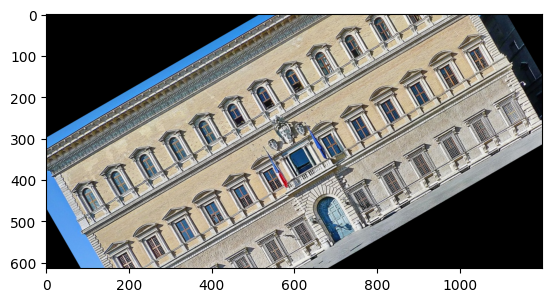

In [5]:
height, width = img_1.shape[:2]
center = (width/2, height/2)

# Definir a matriz de rota ̧c~ao
M = cv.getRotationMatrix2D(center, 30, 1)

# Aplicar a rota ̧c~ao na imagem
rotated_img = cv.warpAffine(img_1, M, (width, height))
plt.imshow(rotated_img)

# Exercício 2 - Transformação Projetiva de uma Imagem

Usaremos a nova imagem Palazzo Farnese Fassad para esta questão:

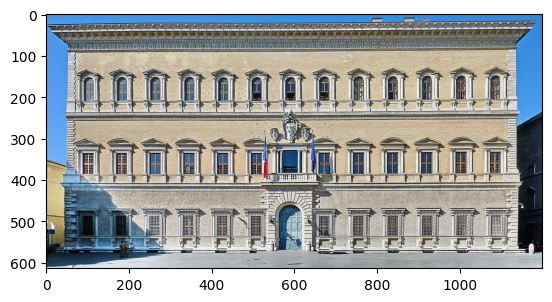

In [6]:
img_2 = cv.imread('./Palazzo_Farnese_Fassade.jpg')
img_2 = img_2[:,:,::-1]
plt.imshow(img_2)

Desta vez, a transformação será dada e apenas a aplicaremos nas posições da imagem.

In [7]:
def my_transform(img:np.ndarray, T:np.ndarray) -> np.ndarray:
    lines, columns = img.shape[:2]
    transform_image = np.zeros((lines, columns, 3), dtype=np.uint8)

    for line in range(lines):
        for col in range(columns):
            pos_orig = np.array([line, col, 1])

            pos_transformed = T @ pos_orig
            
            new_col = int(round(pos_transformed[1]/pos_transformed[2]))
            new_line = int(round(pos_transformed[0]/pos_transformed[2]))
    
            if (new_line >= 0 and new_line < lines) and (new_col >= 0 and new_col < columns):
                transform_image[new_line, new_col] = img[line, col]

    return transform_image

Agora testaremos a função com a projeção no ponto (2000, 0):

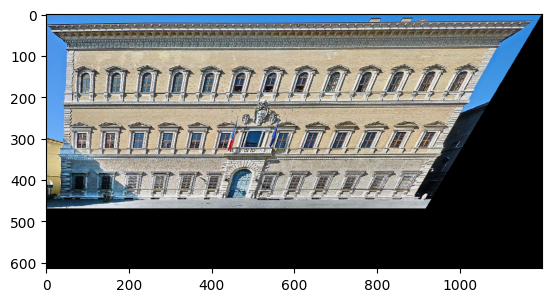

In [8]:
T_1 = np.array([[1, 0, 0],
              [0, 1, 0],
              [1/2000, 0, 1]])

img_transform = my_transform(img_2, T_1)
plt.imshow(img_transform)

# Exercício 3 - Estimação da Transformação Projetiva

## 3.1 - Crie uma função

Escreva uma função que tenha uma como entrada:

1. quatro pontos “fonte” no plano projetivo, possivelmente impr ́oprios,
2. quatro pontos “destino” no plano projetivo, possivelmente impr ́oprios.

E devolva a transformação projetiva $T : RP^2→RP^2$ que leva os pontos
“fonte” nos pontos “destino”.

In [9]:
def my_estimation(lst1:list, lst2:list) -> np.ndarray:
    matriz_origem = np.zeros((3,len(lst1)))
    matriz_destino = np.zeros((3,len(lst2)))

    for i in range(len(lst1)):
        # Montaremos a matriz de origem com os pontos originais e a matriz de destino com os pontos de destino.
        ponto_origem = lst1[i]
        ponto_destino = lst2[i]

        matriz_origem[0,i] = ponto_origem[0]
        matriz_origem[1,i] = ponto_origem[1]
        matriz_origem[2,i] = 1

        matriz_destino[0,i] = ponto_destino[0]
        matriz_destino[1,i] = ponto_destino[1]
        matriz_destino[2,i] = 1

    # Usaremos a função do numpy lstsq para estimar qual é a matriz de transformação
    estimation_T = np.linalg.lstsq(matriz_origem.T, matriz_destino.T, rcond=None)[0]

    return estimation_T.T

Para esta implementação temos a seguinte situação: $A$ (Espaço dos pontos antes da transformação), $B$ (Espaço dos pontos depois da transformação), $T$, matriz que $T:A\rightarrow B$, de fomra análoga, $TA = B$, entretanto é necessário transpor esta situação pois, a função $lstsq$ no numpy apenas acha a solução da matriz que está sendo multiplicada à direita, deste modo, teremos $A^TT^T=B^T$, então devolveremos a matriz $(T^T)^T=T$.

## 3.2 - Teste a função

In [10]:
pontos_origem = [[208, 91], [209, 262], [339, 208], [341, 0]] # Pontos do jogo vasco flamengo
pontos_destino = [[208, 91], [209, 262], [339, 262], [339, 91]] # Pontos de cima

T = my_estimation(pontos_origem, pontos_destino)
print(T)

[[ 9.95464846e-01  5.70259085e-03 -5.60223421e-02]
 [ 4.95256166e-01  8.95878998e-01 -8.49710329e+01]
 [ 2.70053646e-18  0.00000000e+00  1.00000000e+00]]


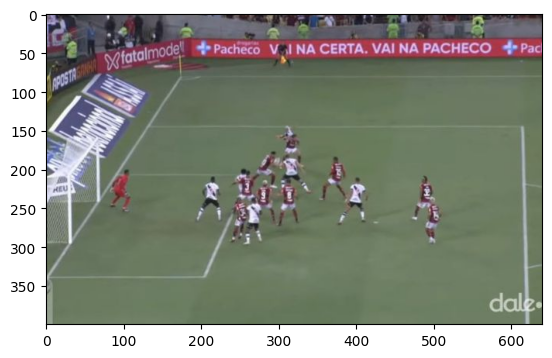

In [11]:
img_3 = cv.imread('./Vasco_Flamengo.jpg')
img_3 = img_3[:,:,::-1]
plt.imshow(img_3)

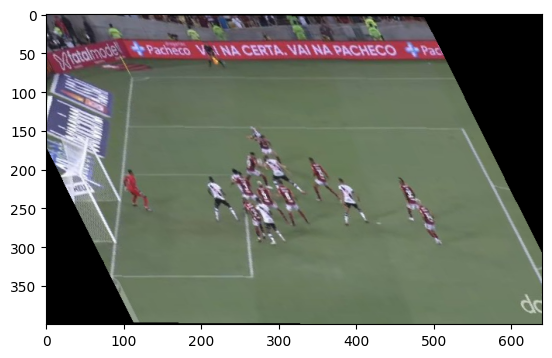

In [12]:
new_transform = my_transform(img_3, T)
plt.imshow(new_transform)

# Exercício 4 - Extra

## 4.1 - You are Fake News ... or maybe not.

Seguindo o que foi feito no [vídeo](https://www.instagram.com/papodeboleiros/reel/CvAhQazvuhu/), leremos a imagem:

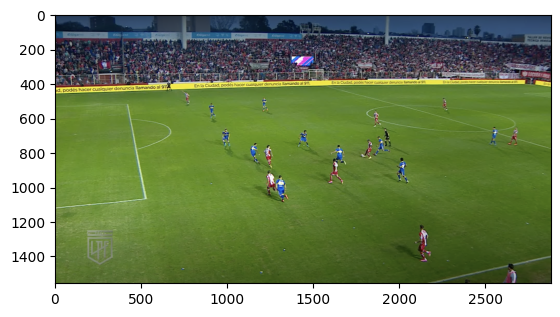

In [13]:
img_4 = cv.imread("./Union_Boca.png")
img_4 = img_4[:,:,::-1]
plt.imshow(img_4)

Agora selecionaremos os pontos:

In [14]:
pontos_origem_2 = [[1055, 520], [510, 415], [455, 1730], [785, 2880]] # Pontos do jogo vasco flamengo
pontos_destino_2 = [[1055, 520*1.3], [455, 520], [455, 1730], [1055, 1730*1.3]] # Pontos de cima

T_2 = my_estimation(pontos_origem_2, pontos_destino_2)
print(T_2)

[[ 1.18524491e+00  1.16639623e-01 -2.37844669e+02]
 [-1.80666069e-01  7.04645629e-01  4.43627078e+02]
 [ 1.60125540e-16 -5.67037736e-17  1.00000000e+00]]


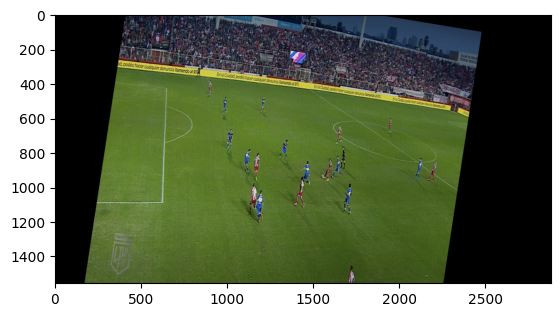

In [15]:
new_transform_2 = my_transform(img_4, T_2)
plt.imshow(new_transform_2)

## 4.2 - My VAR-lidation

In [16]:
def var_idation(img1:np.ndarray, img2:np.ndarray, lst1:list, lst2:list, p1, p2):
    T = my_estimation(lst1=lst1, lst2=lst2)

    p1_destino = T @ p1
    p2_destino = T @ p2

